## Transfer Learning for computer vision tutorial
-  https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
-  Goal : Binary classification (train a model to classify ants and bees)
-  120 training image / 75 validation image
-  Since it's too small to train a model, we will use pretrained network

In [35]:
# Loading packages

from __future__ import print_function, division

import torch 
import torch.nn as nn
import torch.optim as optim

from torch.optim import lr_scheduler

import numpy as np
import torchvision 
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt
import time 
import os
import copy

In [36]:
# data augmentation (transforms)

data_transforms = {
    'train' : transforms.Compose([ # Compose로 여러 transform들을 sequential하게 엮습니다.
            transforms.RandomResizedCrop(224), # 이미지를 랜덤하게 crop함
            transforms.RandomHorizontalFlip(), # 랜덤한 확률로 좌우를 플립
            transforms.ToTensor(), # Tensor로 변경함
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])     
            # 각각 주어진 평균 / 표준편차로 정규화함
    ]),
    'val' : transforms.Compose([
            transforms.Resize(256), # 해당 사이즈로 이미지를 리사이즈
            transforms.CenterCrop(224), # 중간에서 지정한 사이즈로 자른다.
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  
    ])
}

## 왜 validation할때 Resize -> CenterCrop 단계를 거치는 것일까?

In [37]:
# 데이터셋의 경로를 지정해줍니다.
data_dir = './hymenoptera_data/'

# datasets.ImageFolder : 이미지가 포함된 폴더 안의 이미지들에 대해 transform을 적용하여 dataset 형태로 만들기
# datasets.ImageFolder 클래스를 적용하기 위해서는 train/val 폴더 안에 클래스별로 구분하여 파일 들어있어야 함.
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}

# 위의 image_datasets를 활용해서 dataloader 만들기
# 이것이 있어야 학습시 병렬처리 등이 가능합니다.
dataloaders = {x:torch.utils.data.DataLoader(image_datasets[x], 
                                             batch_size = 4,
                                             shuffle = True,
                                             num_workers = 4)
               for x in ['train', 'val']}

# 각각 train / test 데이터셋의 크기를 가져옵니다. 
dataset_sizes = {x:len(image_datasets[x]) for x in ['train', 'val']}
# 각각 클래스의 이름을 가져옵니다.
class_names = image_datasets['train'].classes

# device를 지정하는 부분입니다. gpu가 잡히면 gpu를, 아니면 cpu를 활용합니다.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Visualize a few images

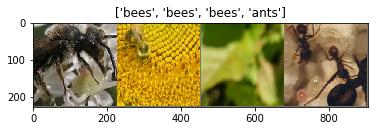

In [38]:
def imshow(inp, title=None):
    """imshow for Tensor"""
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std*inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    

inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
    
imshow(out, title=[class_names[x] for x in classes])

### Training Model

In [52]:
# Training function

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    
    # 학습 시작 시간 저장하기
    since = time.time()
    
    # 모형 적합 전 초기 웨이트를 deep copy 해둡니다. 정확도는 우선 0.0으로
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # 모형을 traning 하는 부분입니다.
    for epoch in range(num_epochs):
        
        # 몇 번째 에폭인지 화면에 출력합니다.
        print("Epoch {} / {}".format(epoch, num_epochs-1))
        print("-" * 10)
        
        # 한 에폭에서 train과 validation을 반복합니다.
        for phase in ['train', 'val']:
            
            # 모형의 train모드와 vaildation 모드를 지정합니다.
            if phase == "train":
                model.train() # Set model to training mode
            else:
                model.eval() # Set model to evaluation mode
                
            # loss와 정답을 초기에 지정해주고    
            running_loss = 0.0
            running_corrects = 0
            
            # train / vaildation 데이터에 따라 데이터를 불러옵니다.
            # dataloader가 알아서 batch로 불러옵니다.
            # dataloader를 정의할때 epoch수, num_workers 모두 지정했습니다.
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                
                # 아래는 항상 나오는 네 단계입니다.
                # 옵티마이져 초기화 -> 예측치 구하고 로스 구하고 -> 
                # loss 역전파 -> optimizer fit 합니다.
                # zero the parameter gradients 
                
                optimizer.zero_grad()
                # forward
                # track history if only in train
                # with 문의 의미는 train 모드에서만 gradient를 계산하라는 뜻
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # train모드라면 역전파 / optimizer 학습해줍니다.
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                        
                # statistics
                # 학습 후 해당 배치의 loss와 정답 개수를 지정함
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            # train 모드라면 learning rate 조정 위한 scheduler 조정하기
            if phase == "train":
                scheduler.step()
                
            # 해당 에폭의 정확도와 accuracy 구함
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print("{} Loss : {:.4f} Acc : {:.4f}".format(phase, epoch_loss, epoch_acc))
            
            # 기존 최고 정확도보다 우수하면 모형 저장
            # deep copy the model
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()    
        
    time_elapsed = time.time() - since
    print("Training complete in {:.0f}".format(time_elapsed // 60, time_elapsed %60))
    print("Best val Acc : {:.4f}".format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

In [49]:
# Visualizing the model predictions

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted : {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(model=was_training)
                    return
                
        model.train(model=was_training)

In [43]:
# Finetunning the Convnet
# pretrained 된 모형을 가지고 와서 마지막 FC만 수정, 적용하는 부분

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=1y)

In [56]:
# ConvNet as fixed feature extractor

model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=1)

In [58]:
model_ft = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0 / 9
----------
train Loss : 0.6292 Acc : 0.6639
val Loss : 0.2508 Acc : 0.9216

Epoch 1 / 9
----------
train Loss : 0.5816 Acc : 0.7377
val Loss : 0.2071 Acc : 0.9412

Epoch 2 / 9
----------
train Loss : 0.4493 Acc : 0.8074
val Loss : 0.2237 Acc : 0.9216

Epoch 3 / 9
----------
train Loss : 0.5541 Acc : 0.7418
val Loss : 0.2646 Acc : 0.8824

Epoch 4 / 9
----------
train Loss : 0.4145 Acc : 0.7992
val Loss : 0.2175 Acc : 0.9412

Epoch 5 / 9
----------
train Loss : 0.5157 Acc : 0.7951
val Loss : 0.2218 Acc : 0.9412

Epoch 6 / 9
----------
train Loss : 0.4765 Acc : 0.7910
val Loss : 0.2076 Acc : 0.9477

Epoch 7 / 9
----------
train Loss : 0.4028 Acc : 0.8033
val Loss : 0.2761 Acc : 0.9346

Epoch 8 / 9
----------
train Loss : 0.4545 Acc : 0.8156
val Loss : 0.1723 Acc : 0.9281

Epoch 9 / 9
----------
train Loss : 0.3977 Acc : 0.8361
val Loss : 0.1900 Acc : 0.9281

Training complete in 5
Best val Acc : 0.9477
